In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from capstone.util import load_kospi_data, load_dataset
import os
import warnings

from matplotlib import ticker
warnings.filterwarnings(action='ignore')
import networkx as nx
import community as community_louvain

In [2]:
pickle_path = './pickle'
kospi_path = './data/kospi200_stocks.xlsx'

interest_rate_increase = {
    "name" : 'interest_rate_increase',
    "start_date" : '2020-01-01',
    "end_date": '2022-03-01'
}
yield_curve_inversion = {
    "name" : "yield_curve_inversion",
    "start_date" : '2018-01-01',
    "end_date": '2019-12-01'
}

In [3]:
kospi_pickle_path = pickle_path + '/kospi_data.pickle'
kospi_data = load_kospi_data(kospi_pickle_path,kospi_path)
interest_rate_pickle_path = pickle_path + f'/{interest_rate_increase["name"]}.pickle'
yield_curve_pickle_path = pickle_path + f'/{yield_curve_inversion["name"]}.pickle'

In [4]:
df_interest_rate = load_dataset(kospi_data,interest_rate_pickle_path,interest_rate_increase['start_date'],interest_rate_increase['end_date'])
tmp = df_interest_rate

# df_yield_curve = load_dataset(kospi_data,yield_curve_pickle_path,yield_curve_inversion['start_date'],yield_curve_inversion['end_date'])
# tmp = df_yield_curve

In [5]:
# interest_rate increase
test_df = tmp[:'2021-01-01']
validation_df = tmp['2021-01-02':]

In [6]:
# # yield curve increase
# test_df = tmp[:'2019-01-01']
# validation_df = tmp['2019-01-02':]

In [7]:
from modularity.calculate_modularity import calculate_louvain
from community import community_louvain

partition,G = calculate_louvain(test_df,threshold=0.15)
modularity_value = community_louvain.modularity(partition,G)
print(f"MODULARITY : {modularity_value}")

MODULARITY : 0.165519692910874


In [8]:
n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

클러스터 갯수 : 2


In [9]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

In [10]:
# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(tmp[dict_clusters[cluster]])

In [11]:
# validation 각 군집별로 데이터프레임 생성
val_clusters_list = []
for cluster in dict_clusters.keys():
    val_clusters_list.append(validation_df[dict_clusters[cluster]])

In [12]:
clusters_list

[Code       A005930 A207940 A005380 A068270 A000270 A035420 A051910 A006400  \
 Date                                                                         
 2020-01-01   55800  427932  120500  168046   44300  186500  317500  236000   
 2020-01-02   55200  423485  118000  167117   42500  182500  314000  232000   
 2020-01-03   55500  417061  116000  164796   42000  181500  311000  229000   
 2020-01-04   55500  417061  116000  164796   42000  181500  311000  229000   
 2020-01-05   55500  417061  116000  164796   42000  181500  311000  229000   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 2022-02-25   71900  760000  174000  149790   73800  314500  554000  539000   
 2022-02-26   71900  760000  174000  149790   73800  314500  554000  539000   
 2022-02-27   71900  760000  174000  149790   73800  314500  554000  539000   
 2022-02-28   72100  779000  175000  153643   73800  318000  565000  548000   
 2022-03-01   72100  779000  175000  153643   73800 

In [13]:
import statsmodels.api as sm

def make_top_20_all_clusters(clusters_list:list)->list:
    top_20_stocks = {}

    # 각 클러스터 별로 K-ratio 계산 및 랭킹 매기기  
    for idx, df_cluster in enumerate(clusters_list):
        # 종목 코드 리스트
        ticker_list = df_cluster.columns

        # 일별 수익률 계산
        returns = df_cluster.pct_change().iloc[1:]
        # 누적 로그 수익률 
        cum_returns = np.log(1 + returns).cumsum()
        # X축 : 기간 
        x = np.array(range(len(returns)))
        K_ratio = {}

        for ticker in ticker_list:
            try:
                y = cum_returns[ticker].values
                # OLS 회귀 분석
                reg = sm.OLS(y, sm.add_constant(x)).fit()
                # K- ratio
                result = float(reg.params[1] / reg.bse[1])
            except:
                result = np.nan
            K_ratio[ticker] = result

        # K-ratio를 데이터 프레임으로 변환
        df_k_ratio = pd.DataFrame.from_dict(K_ratio, orient='index').reset_index()
        df_k_ratio.columns = ['종목코드', 'K_ratio']

        # K-ratio에 따라 종목을 랭킹 
        df_k_ratio['K_ratio_rank'] = df_k_ratio['K_ratio'].rank(axis=0, ascending=False)
        # 상위 n개 종목 추출(10,20,30) 
        top_20 = df_k_ratio[df_k_ratio['K_ratio_rank'] <= 10]
        top_20_stocks[f'cluster_{idx}'] = top_20

    top_20_all_clusters = []
    for cluster_df in top_20_stocks.values():
        top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

    top_20_all_clusters = list(set(top_20_all_clusters))
    return top_20_all_clusters

In [14]:
# 상위 n개의 종목을 합치고 중복을 제거
top_20_all_clusters = make_top_20_all_clusters(clusters_list)

# dataset_1st_year에서 상위 n개 종목들만 추출 
df_momentum = tmp[top_20_all_clusters]

In [15]:
#상위 n개 종목의 모멘텀 나누기

# interest increase
test_df = df_momentum[:'2021-01-01']
validation_df = df_momentum['2021-01-02':]

# yield curve
# test_df = df_momentum[:'2019-01-01']
# validation_df = df_momentum['2019-01-02':]


In [16]:
test_df_pct = test_df.pct_change().dropna()
mean_returns = test_df_pct.mean()
cov_matrix = test_df_pct.cov()

In [17]:
validation_df_pct = validation_df.pct_change().dropna()

In [18]:
from capstone.portfolio_model import mean_variance_portfolio
weight = mean_variance_portfolio(mean_returns, cov_matrix)
weight

array([4.02695286e-16, 5.60473667e-13, 2.51475697e-16, 9.75423129e-14,
       0.00000000e+00, 0.00000000e+00, 6.63067813e-14, 7.50299442e-17,
       9.49328746e-17, 1.34662447e-16, 7.36730838e-14, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.77073572e-16, 1.98802450e-16,
       1.84508495e-16, 0.00000000e+00, 3.34471076e-16, 0.00000000e+00])

In [19]:
result = validation_df_pct @ weight

In [20]:
df_profit_accumulate = (1+result).cumprod()-1

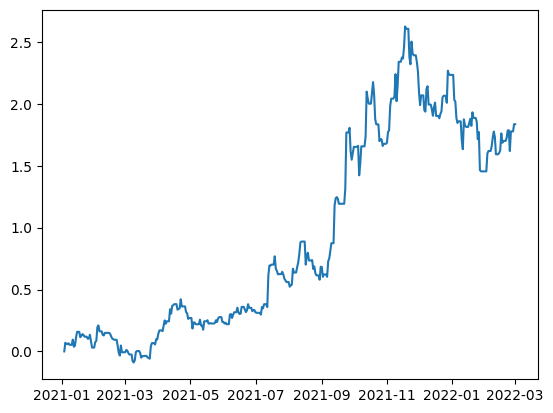

In [21]:
plt.plot(df_profit_accumulate)
plt.savefig('./fig/m_m_m_interestRate.png', format='png', dpi=300)

In [23]:
from capstone.util import make_benchmark_kospi200

benchmark_kospi_202001_202203 = make_benchmark_kospi200('./pickle/202001_202203_KOSPI_200.pickle','2020-01-01','2022-03-01')
benchmark_kospi_201801_201912 = make_benchmark_kospi200('./pickle/201801_201912_KOSPI_200.pickle','2018-01-01','2019-12-01')

In [24]:
from capstone.util import make_cumulative_return

cum_202001_202203 = make_cumulative_return('./pickle/202001_202203_CUM_KOSPI_200.pickle',benchmark_kospi_202001_202203)
cum_201801_201912 = make_cumulative_return('./pickle/201801_201912_CUM_KOSPI_200.pickle',benchmark_kospi_201801_201912)


In [26]:
cum_202001_202203

2020-01-03    0.001343
2020-01-06   -0.006613
2020-01-07    0.003031
2020-01-08   -0.003203
2020-01-09    0.013983
                ...   
2022-02-22    0.251972
2022-02-23    0.255175
2022-02-24    0.222800
2022-02-25    0.234510
2022-02-28    0.245187
Name: Adj Close, Length: 532, dtype: float64

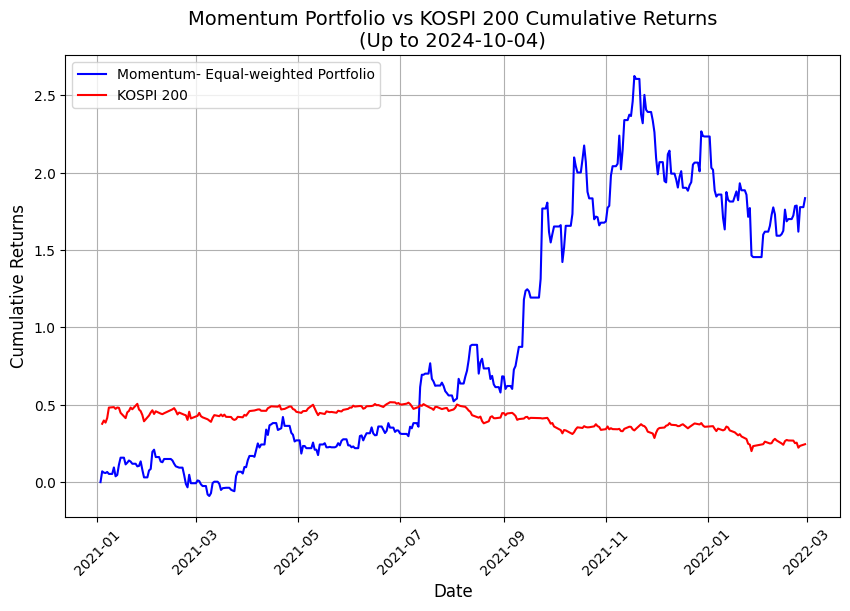

In [27]:
from capstone.util import compare_with_benchmark

compare_with_benchmark(df_profit_accumulate,cum_202001_202203['2021-01-02':],'2021-01-02','2022-02-28')